In [15]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df=pd.read_csv("Hate_Speech.csv")

In [4]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
df["labels"] = df["class"].map({0: "Hate Speech", 
                                    1: "Offensive Language", 
                                    2: "No Hate and Offensive"})
df=df[["tweet","labels"]]

In [6]:
df.head()

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate and Offensive
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive Language
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive Language
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive Language
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive Language


In [7]:
df.shape

(24783, 2)

In [8]:
df.isna().sum()

tweet     0
labels    0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df['labels'].value_counts()

Offensive Language       19190
No Hate and Offensive     4163
Hate Speech               1430
Name: labels, dtype: int64

In [11]:
ps = PorterStemmer()
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
    A=" ".join(y)        
    return A

In [16]:
df['transformed_text'] = df['tweet'].apply(transform_text)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)
from sklearn.model_selection import train_test_split

In [19]:
x = np.array(df["transformed_text"])
y = np.array(df["labels"])
X = tfidf.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)

In [44]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt
}

In [45]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    
    return accuracy

In [46]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy= train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    
    accuracy_scores.append(current_accuracy)

For  SVC
Accuracy -  0.9009658882503974
For  KN
Accuracy -  0.6169458368993764
For  NB
Accuracy -  0.8405673065166891
For  DT
Accuracy -  0.8269959652769288
For  LR
Accuracy -  0.9021885316053307
For  RF
Accuracy -  0.8974202225210905
For  AdaBoost
Accuracy -  0.8908179484044504
For  BgC
Accuracy -  0.8887394547010637
For  ETC
Accuracy -  0.8889839833720504
For  GBDT
Accuracy -  0.8692994253576232


In [47]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores}).sort_values('Accuracy',ascending=False)


In [48]:
performance_df

,Algorithm,Accuracy
4,LR,0.902189
0,SVC,0.900966
5,RF,0.897420
6,AdaBoost,0.890818
8,ETC,0.888984
7,BgC,0.888739
9,GBDT,0.869299
2,NB,0.840567
3,DT,0.826996
1,KN,0.616946


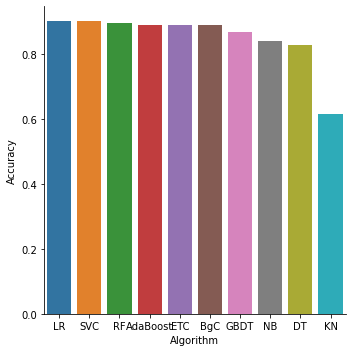

In [49]:
import seaborn as sns
sns.catplot(x = 'Algorithm', y='Accuracy', 
               data=performance_df, kind='bar',height=5)

In [53]:
from sklearn.ensemble import VotingClassifier
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [54]:
voting = VotingClassifier(estimators=[('LR', lrc), ('SVC', svc), ('RF', rfc)],voting='soft')

In [55]:
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('LR',
                              LogisticRegression(penalty='l1',
                                                 solver='liblinear')),
                             ('SVC',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=2))],
                 voting='soft')

In [56]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))

Accuracy 0.9042670253087175


In [57]:
from sklearn.ensemble import StackingClassifier

In [59]:
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [60]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))

Accuracy 0.8980315441985572


In [61]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(voting,open('model.pkl','wb'))